# Setup

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
# Add folder to path
import sys
src_path = '../../code' 
sys.path.insert(0, src_path) 

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.random import dirichlet, gamma, multinomial, normal 

In [5]:
data_df = pd.read_csv("../../data/raw/speed_dating_data.csv", encoding="ISO-8859-1")
data_df.head(1)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [6]:
#for col in data_df.columns:
#    print(col)

In [8]:
# remove duplicate dates
data_m_df = data_df[data_df["gender"] == 1]
data_m_df.shape

(4194, 195)

In [58]:
# extract age differences
ageDiff_df = data_m_df[["age", "age_o", "match"]]
ageDiff_df = ageDiff_df.assign(ageDiff = ageDiff_df["age"] - ageDiff_df["age_o"])

# drop examples with nan values
ageDiff_df = ageDiff_df.dropna()

ageDiff_df.head()

,age,age_o,match,ageDiff
100,27.0,21.0,0,6.0
101,27.0,24.0,0,3.0
102,27.0,25.0,0,2.0
103,27.0,23.0,0,4.0
104,27.0,21.0,0,6.0


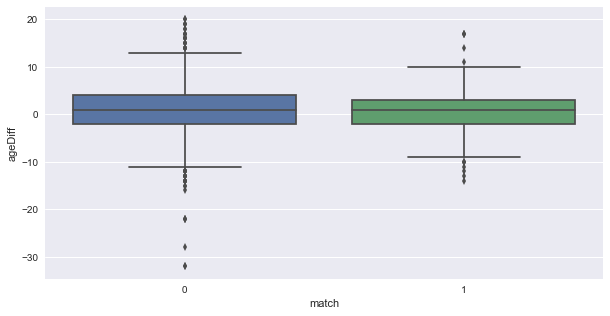

In [111]:
plt.figure(figsize=(10,5))
sns.boxplot(x="match", y="ageDiff", data=ageDiff_df)
plt.show()

In [60]:
print("No match mean:", np.mean(ageDiff_df.loc[ageDiff_df["match"] == 0, "ageDiff"]))
print("Match mean:   ", np.mean(ageDiff_df.loc[ageDiff_df["match"] == 1, "ageDiff"]))

No match mean: 0.5228203627852546
Match mean:    0.5297619047619048


In [214]:
import math
def normpdf(x, mean, tau):
    var = 1/tau
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

# Initiate Model

In [215]:
X = ageDiff_df["ageDiff"].values
y = ageDiff_df["match"].values

In [216]:
iterations = 200
n_classes = 2
n_examples = X.shape[0]

In [217]:
# Initiate variables

# hyperparameters
alpha_pi = [1,1] # paramaterizes dirichlet over pi's
alpha_mu = 0     # paramaterizes guassian over mu's
alpha_tau = 1    # paramaterizes gamma over tau's
beta_tau = 1     # paramaterizes gamma over tau's

# latent variables
pi = dirichlet(alpha_pi) # paramaterizes discrete of z's
mu_vec = np.zeros(2)     # paramaterizes gaussians over x's
tau_vec = np.zeros(2)    # paramaterizes gaussians over x's
for i in range(n_classes):
    mu_vec[i] = normal(alpha_mu, scale=1.0)
    tau_vec[i] = gamma(alpha_tau, 1.0/beta_tau)

z_vec = np.zeros((n_examples, n_classes))
for i in range(n_examples):
    z_vec[i,:] = multinomial(n=1, pvals=pi)

In [218]:
print(pi)
print(mu_vec)
print(tau_vec)

[ 0.11184104  0.88815896]
[-0.98020325 -0.31749703]
[ 0.91909992  1.78755113]


# Gibbs Sampling

In [255]:
# update pi
param_update = pi_beta + np.sum(z_vec, axis=0)
pi = dirichlet(param_update)

print("updated pi:", pi)

updated pi: [ 0.09451144  0.90548856]


In [256]:
# update mu's
for i in range(n_classes):
    c_idx = z_vec[:,i] == 1
    c_examples = np.sum(c_idx)
    
    param1_update = (mu_vec[i] + tau_vec[i]*np.sum(X[c_idx])) / (1 + c_examples*tau_vec[i])
    param2_update = 1 + c_examples*tau_vec[i]
    
    mu_vec[i] = normal(param1_update, 1/param2_update)

print("updated mu_vec:", mu_vec)

updated mu_vec: [-0.36036211  0.63419125]


In [257]:
# update tau's
for i in range(n_classes):
    c_idx = z_vec[:,i] == 1
    c_examples = np.sum(c_idx)
    
    param1_update = alpha_tau + (c_examples / 2)
    param2_update = beta_tau + (np.sum( (X[c_idx] - mu_vec[i])**2 )) / 2
    
    tau_vec[i] = gamma(param1_update, 1.0/param2_update)

print("updated tau_vec:", tau_vec)

updated tau_vec: [ 0.01323405  0.06008138]


In [258]:
# update latent classes
for i in range(n_examples):
    
    # likelihood of class 0
    likelihood_0 = normpdf(X[i], mu_vec[0], tau_vec[0])
    # prior of class 0
    prior_0 = pi[0]
       
    # likelihood of class 1
    likelihood_1 = normpdf(X[i], mu_vec[1], tau_vec[1])
    # prior of class 1
    prior_1 = pi[1]
    
    # marginal likelihood
    Z = (likelihood_0 * prior_0) + (likelihood_1 * prior_1)
    
    # probability of class 0
    prob_0 = (likelihood_0 * prior_0) / Z
    # probability of class 1
    prob_1 = (likelihood_1 * prior_1) / Z
    
    # sample from updated multinomial distribution
    z_vec[i,:] = multinomial(n=1, pvals=[prob_0, prob_1])